# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import joblib

import warnings
warnings.filterwarnings("ignore")

# **Data Gathering**

In [2]:
tourism_df = pd.read_csv('../data/tourism_with_id.csv')
tourism_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


# **Data Cleaning**

In [3]:
tourism_df = tourism_df.drop(columns=['Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'])

# **Exploratory Data Analysis**

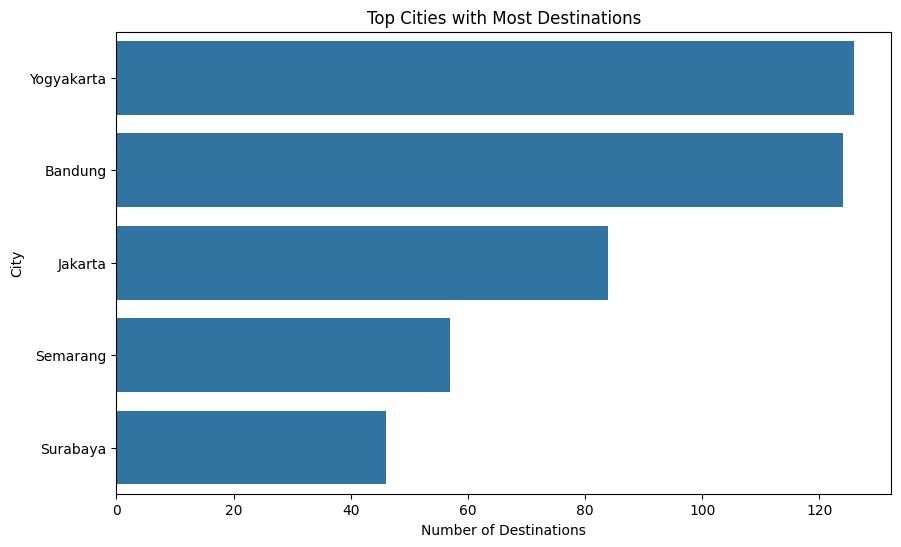

In [4]:
# Top Cities with Most Destinations
city_count = tourism_df['City'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=city_count.values, y=city_count.index)
plt.title('Top Cities with Most Destinations')
plt.xlabel('Number of Destinations')
plt.ylabel('City')
plt.show()

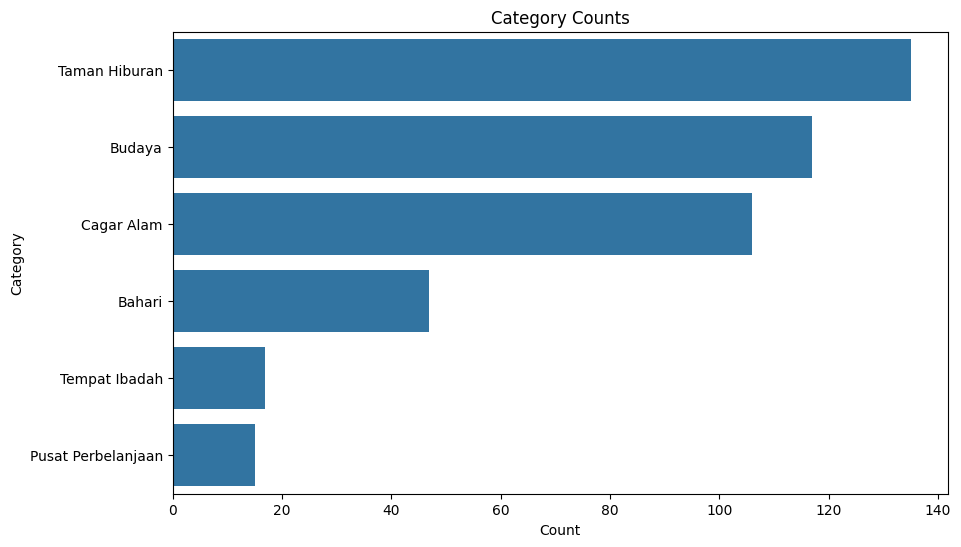

In [5]:
# Category Counts
category_count = tourism_df['Category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_count.values, y=category_count.index)
plt.title('Category Counts')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# **Data Preparation**

In [6]:
def prepare_features(df):    
    # Kombinasikan fitur
    df['combined_features'] = df.apply(lambda row:
        f"{row['Place_Name']} {row['City']} {row['Description']}",
        axis=1
    )
   
    return df

# **Data Augmentation**

In [7]:
def augment_text(text, num_augmentations=2):
    augmented_texts = [text]
    
    # Tambahkan variasi dengan mengacak urutan kata
    words = text.split()
    for _ in range(num_augmentations):
        np.random.shuffle(words)
        augmented_texts.append(' '.join(words))
    
    return augmented_texts

# **Data Processing**

In [8]:
tourism_df = prepare_features(tourism_df)

In [9]:
X = tourism_df['combined_features']
y = tourism_df['Category']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
augment_texts = []
augment_categories = []

In [12]:
for text, category in zip(X_train, y_train):
    augmented_versions = augment_text(text)
    augment_texts.extend(augmented_versions)
    augment_categories.extend([category] * len(augmented_versions))

In [13]:
# create new training dataset with augmented data
X_train_augmented = pd.Series(augment_texts)
y_train_augmented = pd.Series(augment_categories)

In [14]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_augmented).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [15]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_augmented)
y_test_encoded = label_encoder.transform(y_test)

In [16]:
# convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded)

# **Modeling**

In [17]:
# build model
def build_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(1024, input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
input_dim = X_train_tfidf.shape[1]
num_classes = y_train_onehot.shape[1]
model = build_model(input_dim, num_classes)

In [19]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [20]:
# training
history = model.fit(
    X_train_tfidf,
    y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 [==============================] - 3s 19ms/step - loss: 1.4275 - accuracy: 0.4600 - val_loss: 1.7114 - val_accuracy: 0.2429
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6125 - accuracy: 0.8041 - val_loss: 1.6668 - val_accuracy: 0.2571
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 0.2735 - accuracy: 0.9319 - val_loss: 1.6617 - val_accuracy: 0.3000
Epoch 4/100
27/27 [==============================] - 0s 8ms/step - loss: 0.1622 - accuracy: 0.9618 - val_loss: 1.6453 - val_accuracy: 0.3286
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0817 - accuracy: 0.9904 - val_loss: 1.6404 - val_accuracy: 0.2857
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 0.0557 - accuracy: 0.9964 - val_loss: 1.6126 - val_accuracy: 0.2857
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.9976 - val_loss: 1.5758 - val_accuracy: 0.2857
Epoch 8/100


In [21]:
# evaluasi
test_loss, test_accuracy = model.evaluate(X_test_tfidf, y_test_onehot)
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 0s 3ms/step - loss: 0.8076 - accuracy: 0.8182
Test Accuracy: 0.8182


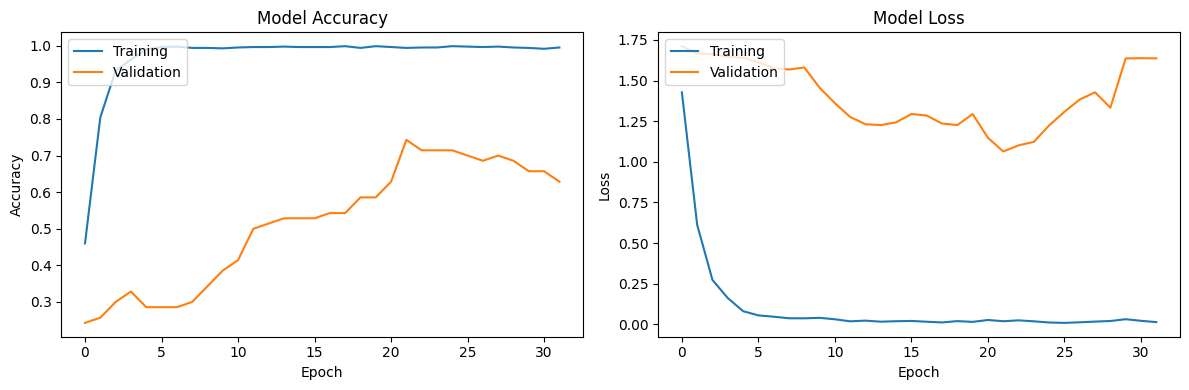

In [22]:
# plot training history
plt.figure(figsize=(12, 4))

# plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 2ms/step


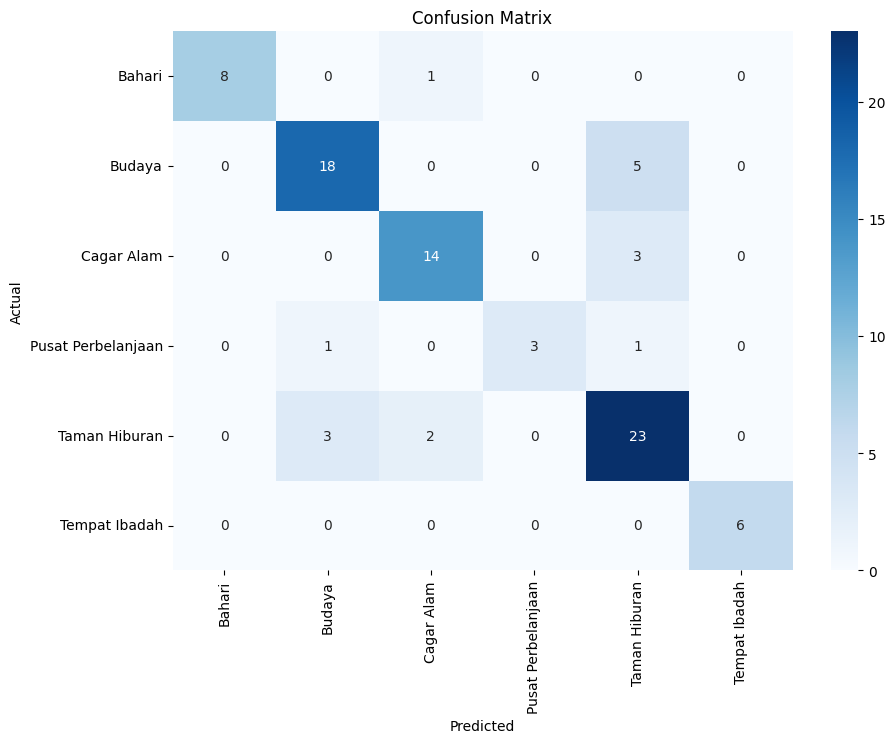

In [23]:
# confusion matrix
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
correcrt_predictions = np.sum(np.argmax(y_pred, axis=1) == y_test_encoded)
total_predictions = len(y_test_encoded)
incorrect_predictions = total_predictions - correcrt_predictions

print(f"Correct Predictions: {correcrt_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")
print(f"Total Predictions: {total_predictions}")

Correct Predictions: 72
Incorrect Predictions: 16
Total Predictions: 88


In [25]:
# classification report
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

                    precision    recall  f1-score   support

            Bahari       1.00      0.89      0.94         9
            Budaya       0.82      0.78      0.80        23
        Cagar Alam       0.82      0.82      0.82        17
Pusat Perbelanjaan       1.00      0.60      0.75         5
     Taman Hiburan       0.72      0.82      0.77        28
     Tempat Ibadah       1.00      1.00      1.00         6

          accuracy                           0.82        88
         macro avg       0.89      0.82      0.85        88
      weighted avg       0.83      0.82      0.82        88



In [26]:
def predict_category(model, tfidf_vectorizer, label_encoder, place_name):
    # Transformasi input menggunakan TF-IDF Vectorizer
    input_vector = tfidf_vectorizer.transform([place_name]).toarray()
    
    # Prediksi menggunakan model
    prediction = model.predict(input_vector)
    
    # Ambil probabilitas prediksi
    probabilities = prediction[0]
    
    # Pasangkan kategori dengan probabilitasnya
    categories = label_encoder.classes_
    category_probs = {cat: float(prob) for cat, prob in zip(categories, probabilities)}
    
    # Cetak probabilitas untuk setiap kategori
    for category, prob in category_probs.items():
        print(f"{category}: {prob:.8f}")
    
    # Tentukan kategori dengan probabilitas tertinggi
    predicted_category_index = np.argmax(probabilities)
    predicted_category = label_encoder.inverse_transform([predicted_category_index])[0]
    
    return predicted_category

In [27]:
# Contoh penggunaan
input_place = "Monumen Nasional"

predicted_category = predict_category(
    model=model,
    tfidf_vectorizer=tfidf_vectorizer,
    label_encoder=label_encoder,
    place_name=input_place,
)

print(f"\nFinal Prediction for {input_place}: {predicted_category}")

1/1 [==============================] - 0s 19ms/step
Bahari: 0.00043559
Budaya: 0.99693131
Cagar Alam: 0.00036294
Pusat Perbelanjaan: 0.00019850
Taman Hiburan: 0.00188485
Tempat Ibadah: 0.00018678

Final Prediction for Monumen Nasional: Budaya


# **Model Save**

In [ ]:
# model.save('../model/tourism_classifier.h5')

In [ ]:
# Konversi ke TFLite untuk Android
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# with open('../model/tourism_classifier.tflite', 'wb') as f:
#     f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmpyuepiiwb\assets


In [ ]:
# simpan vectorizer
# joblib.dump(tfidf_vectorizer, '../model/tfidf_vectorizer.pkl')

['../model/tfidf_vectorizer.pkl']

In [ ]:
# simpan label encoder
# joblib.dump(label_encoder, '../model/label_encoder.pkl')

['../model/label_encoder.pkl']